# Flowise - No/Low code solution

## Abstraction levels

There are several methods for interacting with GenAI APIs with varying degrees of abstraction.

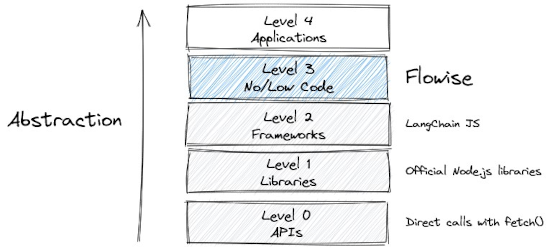

We visited the first three levels in the previous videos. Let's now move to Level 3 and the use of a No/Low code solution.

## Introducing Flowise

[Flowise](https://github.com/FlowiseAI/Flowise) is graphical open source solution sitting on top of LangChain JS. It allows to create and run flows by composing LangChain components.

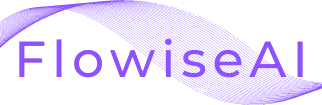


## First example: simple chat with OpenAI

Let's start with a simple flow to implement a chat with OpenAI.

We first need to install Flowise from the [NPM repository](https://www.npmjs.com/package/flowise).

```
npm install flowise
npx flowise start
```

And we then browse the GUI at http://genai.lamp:3000

We design the following flow and declare our OpenAI API Key.

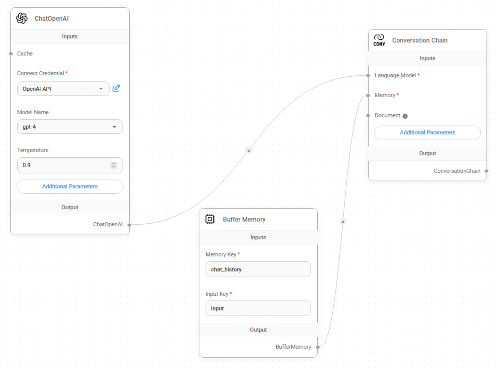

We can test the chat directly from the Flowise GUI with the provided chat window.

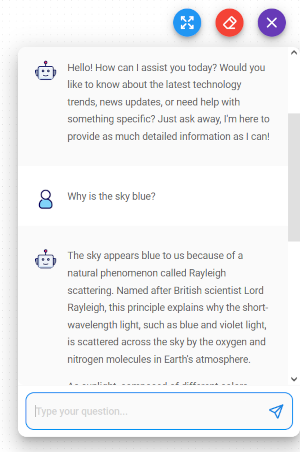

We can also embed the window in a Web page, for instance this very notebook!

In [1]:
var script = `
<script type="module">
    import Chatbot from "https://cdn.jsdelivr.net/npm/flowise-embed/dist/web.js"
    Chatbot.init({
        chatflowid: "5a8d6870-a2d1-450c-9cbe-b23446aa90c8",
        apiHost: "http://genai.lamp:3000",
    })
</script>`

var element = $$.display("script");
element.html(script);

The popup window can be customized by checking the *Show Embed Chat Config* box in Flowise and modifying widget parameters. We can alter colors, avatars, and messages.

For more extensive customization, fork the [Flowise Chat Embed](https://github.com/FlowiseAI/FlowiseChatEmbed) repository on GitHub and modify the widget's source code. Update the embedding script to import code from your forked repository.

## Second example: RAG with VertexAI and Chroma

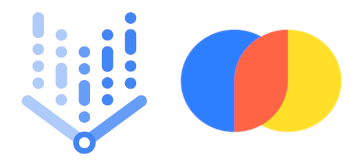

### Retreival Augmented Generation pattern

Retreival Augmented Generation (RAG) is an architectural pattern to contextualize responses made by a LLM by injecting new snippets of knowledge (embeds) at runtime into the prompt sent to the model.

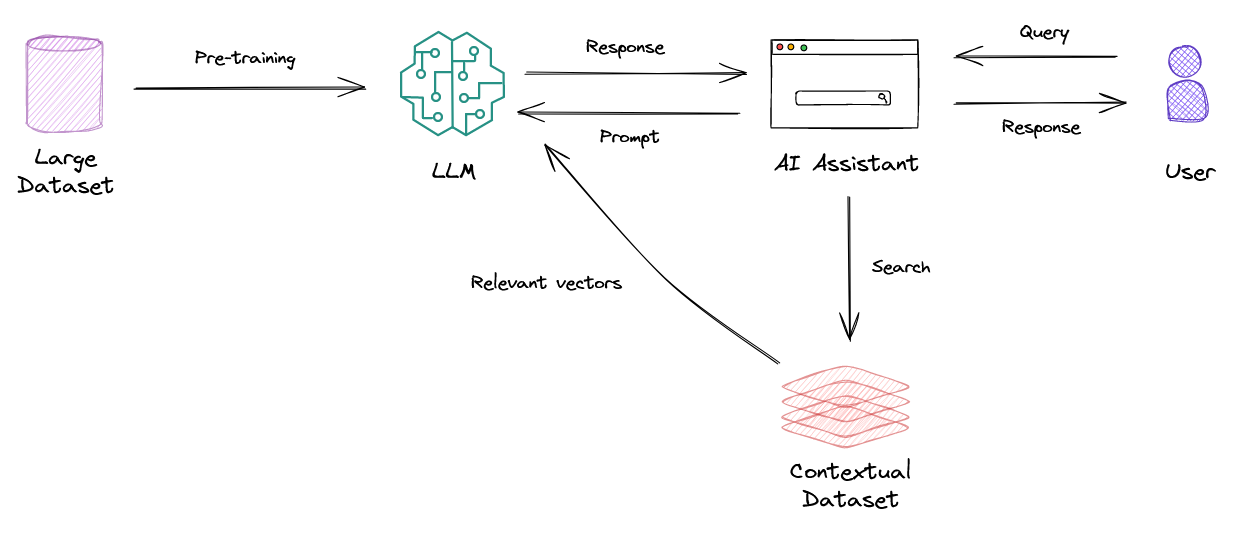

To implement this pattern we need to create the contextual dataset by calling the *Embedding API* of VertexAI, store the return vector in a database (called vectorstore) and implement a flow using this contextual element based on the user's initial prompt.

### Chroma container

For our simple example let's use the [Chroma](https://www.trychroma.com) open source vectorstore and a single PDF file to create our dataset.

We start by installing a Chroma Docker container.

```
git clone https://github.com/chroma-core/chroma.git && cd chroma
docker compose up -d --build
```

We can check Chroma's API availability by navigating to  http://genai.lamp:8000/docs or making an API call:

In [ ]:
fetch('http://genai.lamp:8000/api/v1/count_collections?tenant=default_tenant&database=default_database', {
  method: "GET",
  headers: { "Content-Type": "application/json" }
})
  .then((response) => response.json())
  .then((json) => console.log(json));

### Flowise container

Now we get and configure the Flowise container to be in the same virtual network as Chroma.

```
git clone https://github.com/FlowiseAI/Flowise.git && cd Flowise/docker
cp .env.example .env
vi docker-compose.yml
```

We edit the `docker-compose.yml` file as follows:
```
version: '3.1'

services:
    flowise:
        image: flowiseai/flowise
        restart: always
        environment:
            - PORT=${PORT}
            - FLOWISE_USERNAME=${FLOWISE_USERNAME}
            - FLOWISE_PASSWORD=${FLOWISE_PASSWORD}
            - DEBUG=${DEBUG}
            - DATABASE_PATH=${DATABASE_PATH}
            - APIKEY_PATH=${APIKEY_PATH}
            - SECRETKEY_PATH=${SECRETKEY_PATH}
            - FLOWISE_SECRETKEY_OVERWRITE=${FLOWISE_SECRETKEY_OVERWRITE}
            - LOG_PATH=${LOG_PATH}
            - LOG_LEVEL=${LOG_LEVEL}
            - EXECUTION_MODE=${EXECUTION_MODE}
        ports:
            - '${PORT}:${PORT}'
        volumes:
            - ~/.flowise:/root/.flowise
        networks:
            - flowise_net
        command: /bin/sh -c "sleep 3; flowise start"
networks:
    flowise_net:
        name: chroma_net
        external: true
```

And launch the container :
```
docker compose up -d
```

### RAG flow

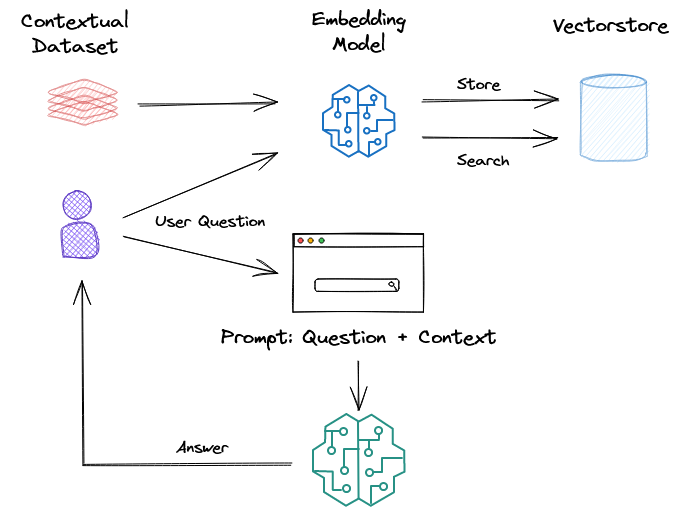

Several steps are to be implemented in the RAG pattern:
- open the PDF file, make the necessary API calls to get the embeddings and store them in the vectorstore
- also convert the initial prompt to an embedding, make a similarity search into the vectorestore and get the most relevant vectors
- then inject these vector into the prompt en call the *Text Completion API* of VertexAI to get and display the contecxtualized response.


Let's design the flow from the Flowise console.

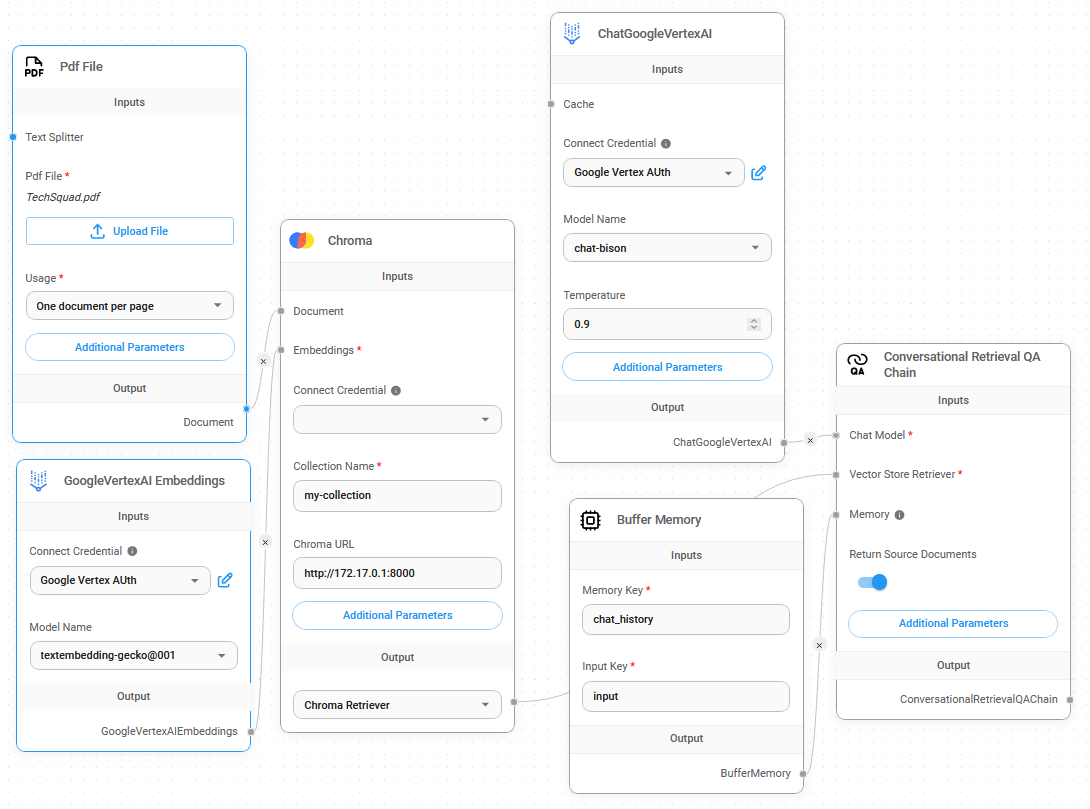

Like in the first example it is also possible to embed a chatboc in a Web page. Let's call the exposed Flowise API this time to get an answer from our contextualized chatbot.

In [2]:
async function query(data) {
    const response = await fetch(
        "http://genai.lamp:3000/api/v1/prediction/03419e24-3cb2-4cf3-9f32-66ee7d3b0ce9",
        {
            method: "POST",
            headers: {
                "Content-Type": "application/json"
            },
            body: JSON.stringify(data)
        }
    );
    const result = await response.json();
    return result;
}

query({"question": "What is the TechSquad?"}).then((response) => {
    console.log(response.text);
});


Promise { <pending> }

 TechSquad is a group of 50 elected tech experts who contribute 20% of their time to TechSquad activities. There are 7 squads that work on different areas of technology and operations.


That's it for this very quick tutorial. Flowise supports many other components (those from LangChain JS) and allow to build more specialized or complex flows.

## Thank you!